# Pattern Substitution Risk


(np.float64(-0.5), np.float64(767.5), np.float64(1023.5), np.float64(-0.5))

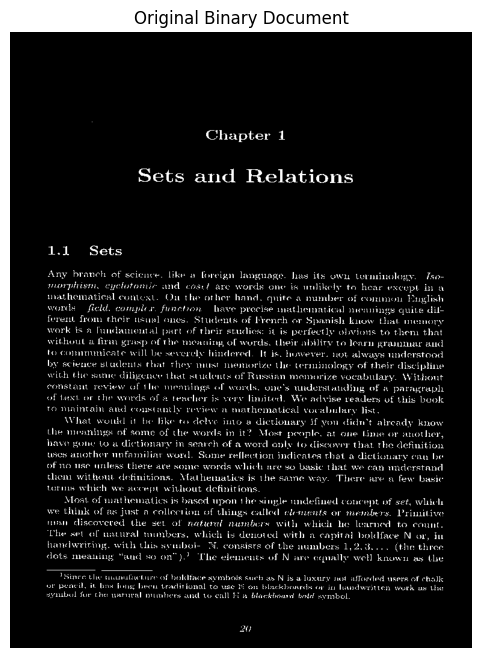

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load document image
img = cv2.imread("setr1.jpg", cv2.IMREAD_GRAYSCALE)

# Binarize (text = white, background = black)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(6,8))
plt.imshow(binary, cmap="gray")
plt.title("Original Binary Document")
plt.axis("off")


In [17]:
from skimage.measure import label, regionprops

labels = label(binary)
regions = regionprops(labels)

components = []
for r in regions:
    components.append({
        "area": r.area,
        "bbox": r.bbox,
        "coords": r.coords
    })

print("Total connected components (symbols):", len(components))


Total connected components (symbols): 3937


In [18]:
def similar(c1, c2, threshold):
    return abs(c1["area"] - c2["area"]) / c1["area"] < threshold


In [19]:
def group_components(components, threshold):
    groups = []
    for c in components:
        placed = False
        for g in groups:
            if similar(c, g[0], threshold):
                g.append(c)
                placed = True
                break
        if not placed:
            groups.append([c])
    return groups


In [20]:
def reconstruct_image(groups, shape):
    reconstructed = np.zeros(shape, dtype=np.uint8)

    for group in groups:
        prototype = group[0]   # single stored glyph
        proto_coords = prototype["coords"]

        for c in group:
            minr, minc, _, _ = c["bbox"]
            for (r, col) in proto_coords:
                rr = r - prototype["bbox"][0] + minr
                cc = col - prototype["bbox"][1] + minc
                if 0 <= rr < shape[0] and 0 <= cc < shape[1]:
                    reconstructed[rr, cc] = 255
    return reconstructed


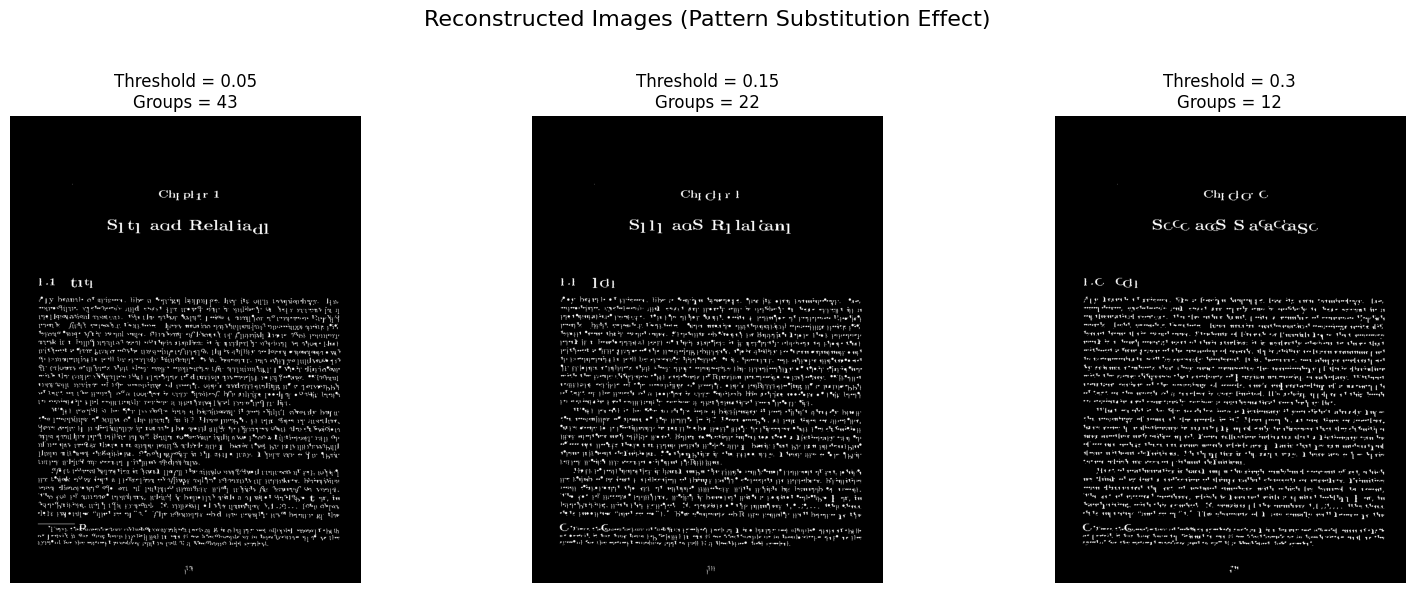

In [21]:
thresholds = [0.05, 0.15, 0.30]

plt.figure(figsize=(16,6))

for i, t in enumerate(thresholds):
    groups = group_components(components, t)
    recon = reconstruct_image(groups, binary.shape)

    plt.subplot(1, len(thresholds), i+1)
    plt.imshow(recon, cmap="gray")
    plt.title(f"Threshold = {t}\nGroups = {len(groups)}", fontsize=12)
    plt.axis("off")


plt.tight_layout(rect=[0, 0, 1, 0.90])

plt.suptitle("Reconstructed Images (Pattern Substitution Effect)", fontsize=16)

plt.show()

#As the threshold increases, similar-looking characters get grouped together and different letters start merging


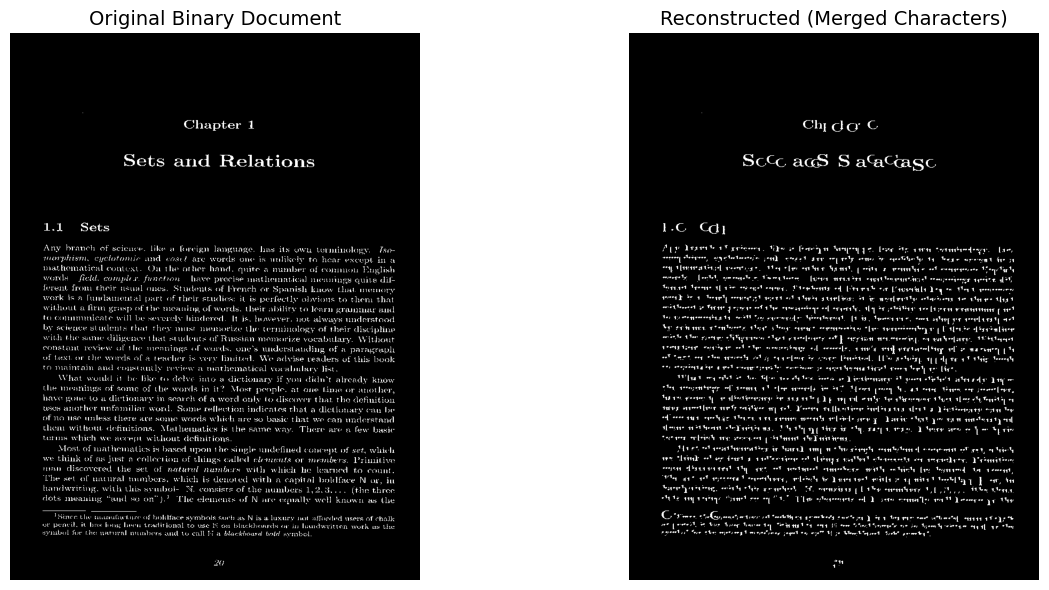

In [22]:

groups = group_components(components, threshold=0.3)
reconstructed = reconstruct_image(groups, binary.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(binary, cmap="gray")
plt.title("Original Binary Document", fontsize=14)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(reconstructed, cmap="gray")
plt.title("Reconstructed (Merged Characters)", fontsize=14)
plt.axis("off")

plt.tight_layout()
plt.show()

#The page still looks the same overall, but the text is distorted because characters have been wrongly replaced.


# Human-Visible vs Machine-Relevant Differences

(np.float64(-0.5), np.float64(767.5), np.float64(1023.5), np.float64(-0.5))

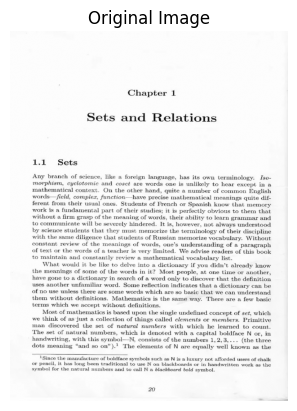

In [23]:
import cv2
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread("setr1.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")


In [24]:
qualities = [90, 50, 20]

for q in qualities:
    cv2.imwrite(f"text_q{q}.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, q])


In [25]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

for q in qualities:
    comp = cv2.imread(f"text_q{q}.jpg", cv2.IMREAD_GRAYSCALE)

    psnr = peak_signal_noise_ratio(img, comp)
    ssim = structural_similarity(img, comp)

    print(f"Quality {q} → PSNR: {psnr:.2f}, SSIM: {ssim:.3f}")

    #PSNR and SSIM stay fairly high, so humans feel the image still looks okay.


Quality 90 → PSNR: 41.71, SSIM: 0.991
Quality 50 → PSNR: 30.63, SSIM: 0.953
Quality 20 → PSNR: 26.55, SSIM: 0.923


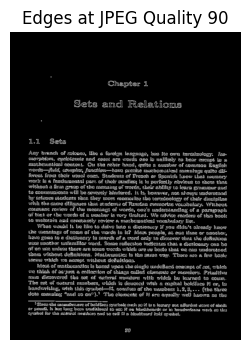

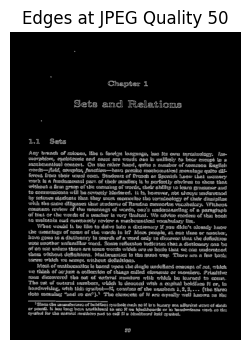

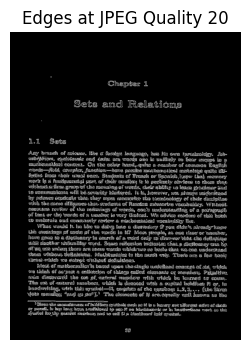

In [26]:
for q in qualities:
    comp = cv2.imread(f"text_q{q}.jpg", cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(comp, 100, 200)

    plt.figure(figsize=(4,4))
    plt.imshow(edges, cmap="gray")
    plt.title(f"Edges at JPEG Quality {q}")
    plt.axis("off")
    plt.show()

    #As compression increases,edges break and become noisy which machines notice more than humans.


# Silent Data Corruption Detection

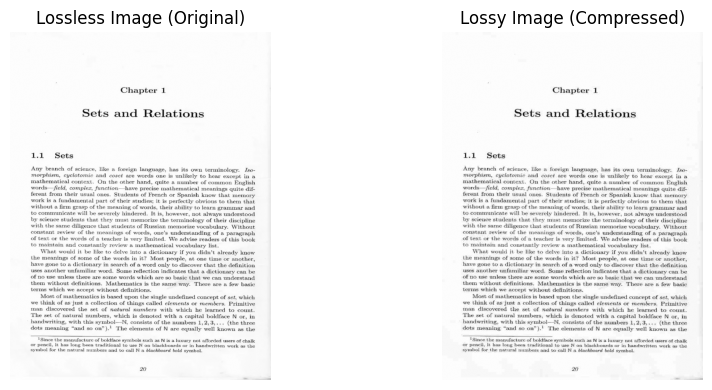

In [27]:
import cv2
import matplotlib.pyplot as plt

# Lossless (original document)
lossless = cv2.imread("setr1.jpg", cv2.IMREAD_GRAYSCALE)

# Lossy (compressed version)
lossy = cv2.imread("text_q20.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(lossless, cmap="gray")
plt.title("Lossless Image (Original)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(lossy, cmap="gray")
plt.title("Lossy Image (Compressed)")
plt.axis("off")

plt.tight_layout()
plt.show()



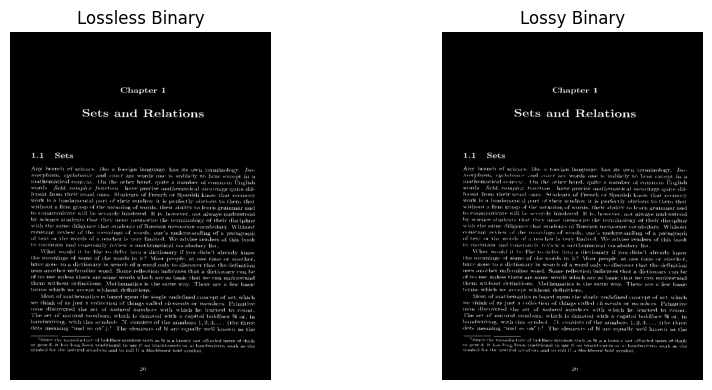

In [28]:
_, bin_lossless = cv2.threshold(lossless, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_lossy = cv2.threshold(lossy, 127, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(bin_lossless, cmap="gray")
plt.title("Lossless Binary")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(bin_lossy, cmap="gray")
plt.title("Lossy Binary")
plt.axis("off")

plt.tight_layout()
plt.show()


In [29]:
from skimage.measure import label, regionprops

labels_lossless = label(bin_lossless)
labels_lossy = label(bin_lossy)

regions_lossless = regionprops(labels_lossless)
regions_lossy = regionprops(labels_lossy)

print("Connected components (lossless):", len(regions_lossless))
print("Connected components (lossy):", len(regions_lossy))


Connected components (lossless): 3937
Connected components (lossy): 4100


In [30]:
areas_lossless = [r.area for r in regions_lossless]
areas_lossy = [r.area for r in regions_lossy]

print("Average component area (lossless):", np.mean(areas_lossless))
print("Average component area (lossy):", np.mean(areas_lossy))



Average component area (lossless): 9.982981965963932
Average component area (lossy): 9.119024390243903


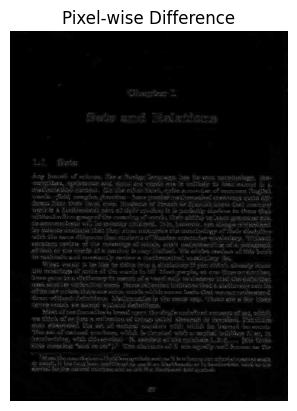

In [31]:
diff = cv2.absdiff(lossless, lossy)

plt.imshow(diff, cmap="gray")
plt.title("Pixel-wise Difference")
plt.axis("off")
plt.show()



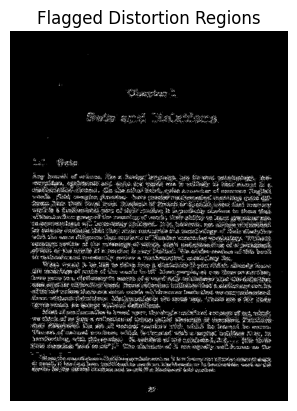

In [32]:
_, diff_bin = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)

plt.imshow(diff_bin, cmap="gray")
plt.title("Flagged Distortion Regions")
plt.axis("off")
plt.show()

#Compression causes tiny hidden changes inside text characters.



# When Compression Breaks a Downstream Task

(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

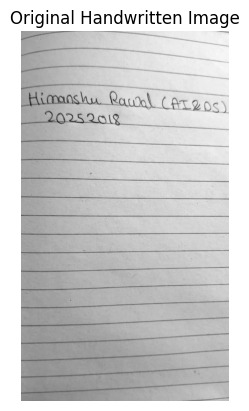

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load handwritten image
img = cv2.imread("ocr.jpeg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Original Handwritten Image")
plt.axis("off")


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

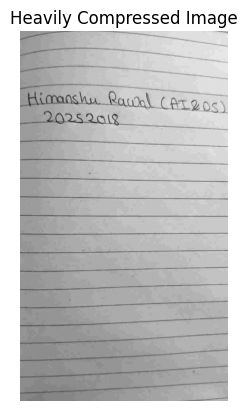

In [34]:
# Save heavily compressed version
cv2.imwrite("ocr_compressed.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 20])

compressed = cv2.imread("ocr_compressed.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(compressed, cmap="gray")
plt.title("Heavily Compressed Image")
plt.axis("off")


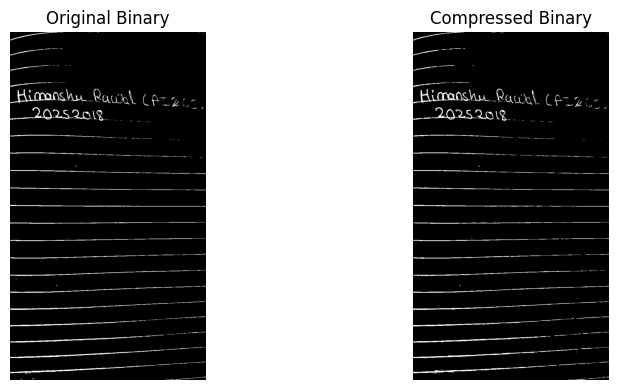

In [35]:
_, bin_orig = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_comp = cv2.threshold(compressed, 127, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(bin_orig, cmap="gray")
plt.title("Original Binary")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(bin_comp, cmap="gray")
plt.title("Compressed Binary")
plt.axis("off")

plt.tight_layout()
plt.show()


In [36]:
from skimage.measure import label, regionprops

labels_orig = label(bin_orig)
labels_comp = label(bin_comp)

regions_orig = regionprops(labels_orig)
regions_comp = regionprops(labels_comp)

print("Characters detected (original):", len(regions_orig))
print("Characters detected (compressed):", len(regions_comp))


Characters detected (original): 139
Characters detected (compressed): 110


In [37]:
def simple_char_recognizer(region):
    h, w = region.image.shape
    if h > 2*w:
        return "I / l"
    elif w > 2*h:
        return "-"
    else:
        return "Other"


In [38]:
def evaluate(regions):
    recognized = 0
    for r in regions:
        label = simple_char_recognizer(r)
        if label != "Other":
            recognized += 1
    return recognized / len(regions)

acc_orig = evaluate(regions_orig)
acc_comp = evaluate(regions_comp)

print("Recognition Accuracy (Original):", round(acc_orig, 2))
print("Recognition Accuracy (Compressed):", round(acc_comp, 2))


Recognition Accuracy (Original): 0.65
Recognition Accuracy (Compressed): 0.69


In [39]:
small_chars = [r for r in regions_comp if r.area < 50]
print("Small / broken characters after compression:", len(small_chars))
#Thin characters fail first because compression removes fine details, leading to shape distortion and pattern substitution.


Small / broken characters after compression: 58


# Designing a Safe Compression Rule


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [41]:
# Text document
text_img = cv2.imread("setr1.jpg", cv2.IMREAD_GRAYSCALE)

# Form / handwritten text
form_img = cv2.imread("ocr.jpeg", cv2.IMREAD_GRAYSCALE)

# Photo-like image (any natural image you have)
photo_img = cv2.imread("dig.png", cv2.IMREAD_GRAYSCALE)


In [42]:
def entropy(image):
    hist = np.histogram(image.flatten(), bins=256)[0]
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))


In [43]:
def edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0) / edges.size


In [44]:
def compression_decision(image):
    e = entropy(image)
    d = edge_density(image)

    if d > 0.15:
        return "Use LOSSLESS compression"
    elif e < 4:
        return "LOSSY compression is safe"
    else:
        return "Use HIGH-QUALITY lossy compression"


In [45]:
print("Text Image Decision:", compression_decision(text_img))


Text Image Decision: LOSSY compression is safe


In [46]:
print("Form Image Decision:", compression_decision(form_img))


Form Image Decision: Use HIGH-QUALITY lossy compression


In [47]:
print("Photo Image Decision:", compression_decision(photo_img))


Photo Image Decision: LOSSY compression is safe


In [48]:
import cv2

# Change this filename to test any image
img = cv2.imread("dig.png", cv2.IMREAD_GRAYSCALE)


In [49]:
decision = compression_decision(img)
print("Recommended Compression:", decision)


Recommended Compression: LOSSY compression is safe


In [50]:
img = cv2.imread("ocr.jpeg", cv2.IMREAD_GRAYSCALE)

In [51]:
decision = compression_decision(img)
print("Recommended Compression:", decision)


Recommended Compression: Use HIGH-QUALITY lossy compression
